# Zustandsreglerentwurf

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import display, Image, Latex, Markdown
from scipy.integrate import solve_ivp
import control

# user imports
from models import linSys, nonLinSys
from controller import ZustandsRegler
from feedforward import Steuerung
from simulate import simu_nlin_noFF, simu_lin_noFF, simu_lin_withFF, simu_nlin_withFF
from plotting import three_stack_plot, three_stack_plot_FF

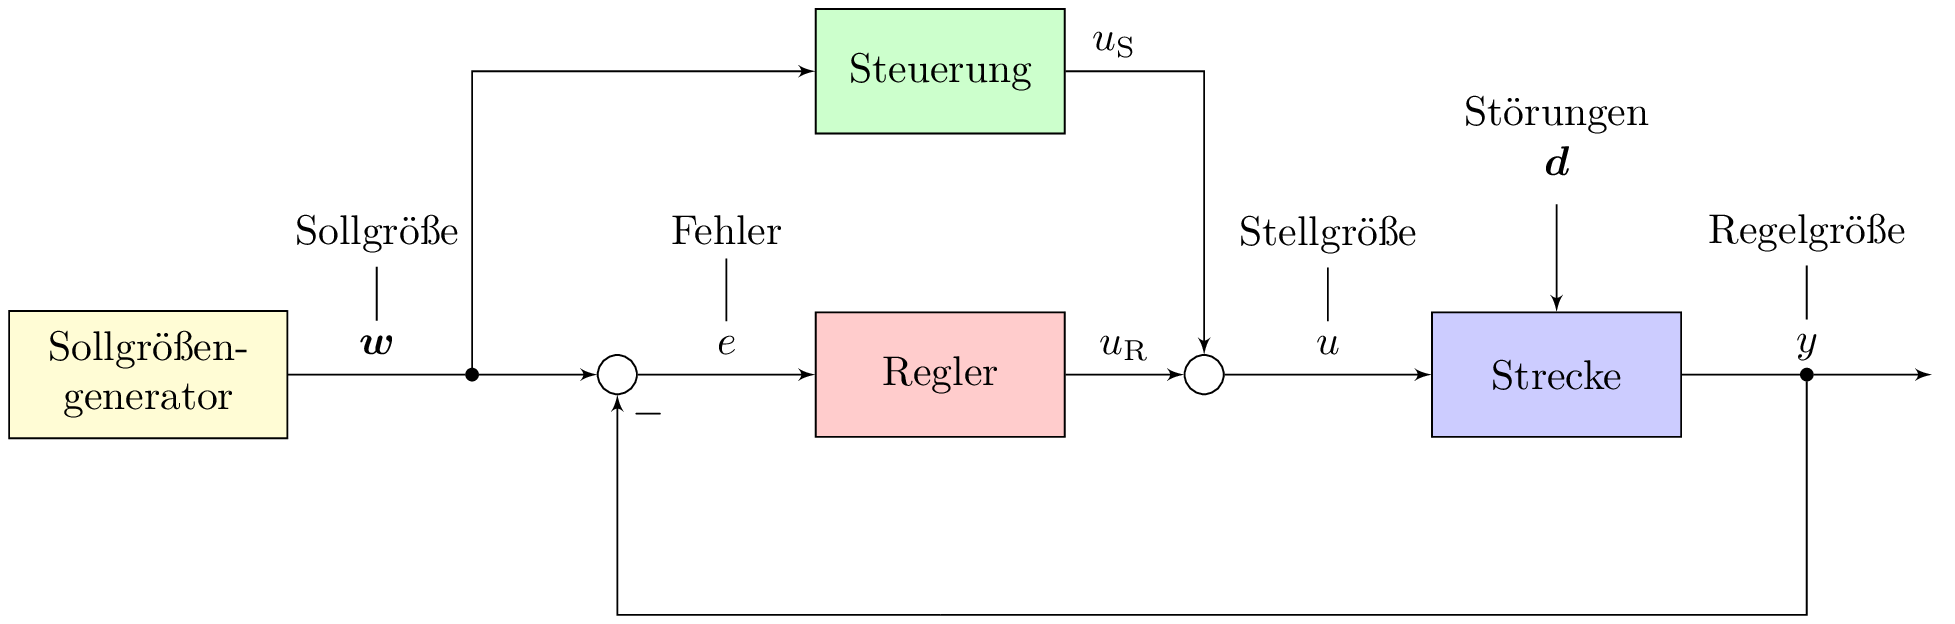

In [2]:
imag = Image("../images/feedback.png", width=600)
display(imag)

Ziel ist der Entwurf eines Zustandsreglers auf Basis des linearisierten Modells des Zweitanksystems.
Dazu wird eine Zustandsrückführung in der Form durchgeführt, dass
\begin{align*}
    u_{\text{R}}(t) & = -\mathbf{k}^{\intercal} \mathbf{e}(t)
\end{align*}
mit der Zustandsverstärkung $\mathbf{k}$ und dem Fehler $\mathbf{e}$ der sich aus dem entsprechenden Zustandskomponenten ergibt.

Es werden im Folgenden zwei Methoden unterschieden.
1. Eingangs-Ausgangsbeziehung mit dem Zustand
   \begin{align*}
       \mathbf{x} = \begin{pmatrix}x_1 \\ x_2 \end{pmatrix} = \begin{pmatrix}y \\ \dot{y} \end{pmatrix}
   \end{align*}
   auf Basis der gemessenen Größe $y$
2. Regelungsnormalform mit dem Zustand
   \begin{align*}
       \mathbf{x} = \begin{pmatrix}x_1 \\ x_2 \end{pmatrix} = \begin{pmatrix}\eta \\ \dot{\eta} \end{pmatrix}
   \end{align*}
   auf Basis des flachen Ausgangs $\eta$

### 1. Eintragen der notwendigen Systemparameter

In [3]:
buA = 9
# Physikalisch EA-Darstellung
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz1Phy = 0.0423458650804235
bz2Phy = 0.137092448385557
# Messung EA-Darstellung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz1Phy = 0.0423458650804235
bz2Messung = 0.13238994944989588
# Messung allgemeine Darstellung
a11 = -0.0847706345855032
a21 = 0.14656849835105779
a22 = -0.01238528441582823
b1 = 0.00038219872357851876

In [4]:
APhyLin = np.array([[0, 1],
                    [-1 / (T1Phy * T2Phy), -(T1Phy + T2Phy) / (T1Phy * T2Phy)]])
BPhyLin = np.array([[0],
                    [KPhy / (T1Phy * T2Phy)]])

AEAMessung = np.array([[0, 1],
                       [-1 / (T1Messung * T2Messung), -(T1Messung + T2Messung) / (T1Messung * T2Messung)]])
BEAMessung = np.array([[0],
                       [KMessung / (T1Messung * T2Messung)]])

AGenMessung = np.array([[a11, 0],
                        [a21, a22]])
BGenMessung = np.array([[b1],
                        [0]])

### 2. Setup simulation parameters

In [5]:
timeDom = np.linspace(0, 500, 5001)
z2Soll = 0.15
dt = 150

### 3. Zustandsregler über Eingangs-Ausgangsbeziehung

In [46]:
a0EA = 1 / (T1Messung * T2Messung)
a1EA = (T1Messung + T2Messung) / (T1Messung * T2Messung)
bEA = KMessung / (T1Messung * T2Messung)

x0 = 0 - bz2Messung
x1 = z2Soll - bz2Messung

kEA = np.array([20, 40])
TEA = np.array([[1, 0],
                [0, 1]])

In [47]:
regler = ZustandsRegler(kEA, TEA, 0 - buA, 12 - buA, timeDom[1])
steuerung = Steuerung(x0, x1, 0, dt, a0EA, a1EA, bEA)

#### Regler ohne Steuerung

In [48]:
setPoint = np.array([bz2Phy, bz1Phy])
z0 = [0, 0]
zNLin, uNLin = simu_nlin_noFF(regler, timeDom, z0, setPoint)

In [49]:
setPoint = np.array([0, 0])
z0 = [0, 0] - np.array([bz2Phy, 0])
zLinPhy, uLinPhy = simu_lin_noFF(regler, timeDom, z0, setPoint, APhyLin, BPhyLin)

In [50]:
setPoint = np.array([0, 0])
z0 = [0, 0] - np.array([bz2Messung, 0])
zLinMes, uLinMes = simu_lin_noFF(regler, timeDom, z0, setPoint, AEAMessung, BEAMessung)

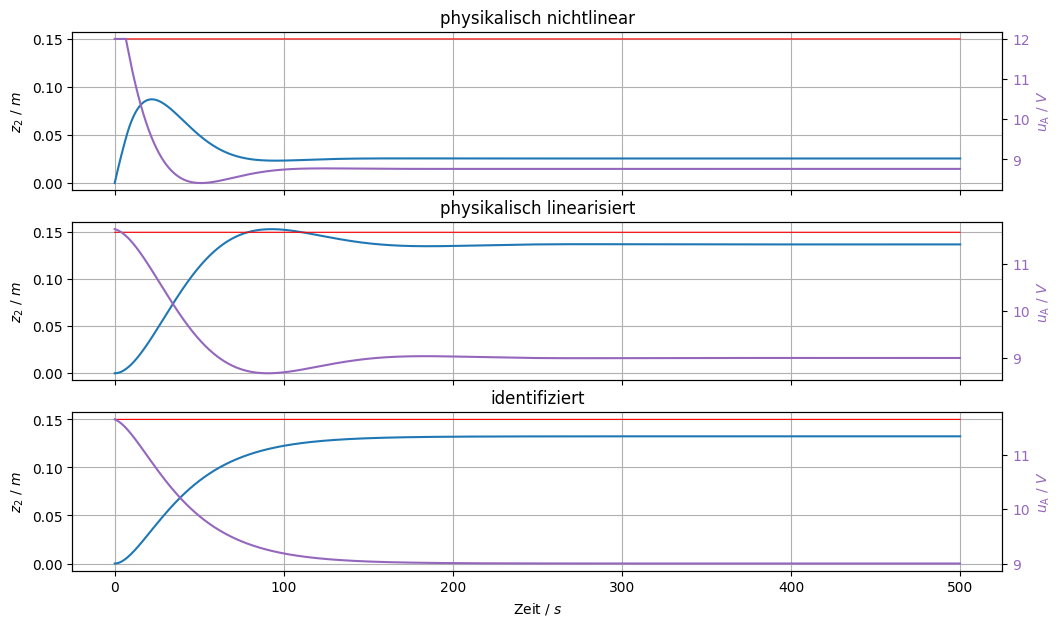

In [51]:
three_stack_plot(timeDom, zNLin, uNLin, zLinPhy, uLinPhy, bz2Phy, zLinMes, uLinMes, bz2Messung, refLine=z2Soll)

das nichtlineare Modell ist stationär auch nicht auf dem richtigen Wert. Um das zu beheben, könnte man entweder einen PI-Zustandsregler implementieren oder einen Vorfaktor miteinbringen.

#### Regler mit Steuerung

In [52]:
z0 = [0, 0]
zNLin, z2NLinFF, uNLin = simu_nlin_withFF(regler, steuerung, timeDom, z0, bz2Messung)

In [53]:
z0 = [0, 0 ]- np.array([bz2Phy, 0])
zLinPhy, z2LinPhyFF, uLinPhy = simu_lin_withFF(regler, steuerung, timeDom, z0, APhyLin, BPhyLin)

In [54]:
z0 = [0, 0 ]- np.array([bz2Messung, 0])
zLinMes, z2LinMesFF, uLinMes = simu_lin_withFF(regler, steuerung, timeDom, z0, AEAMessung, BEAMessung)

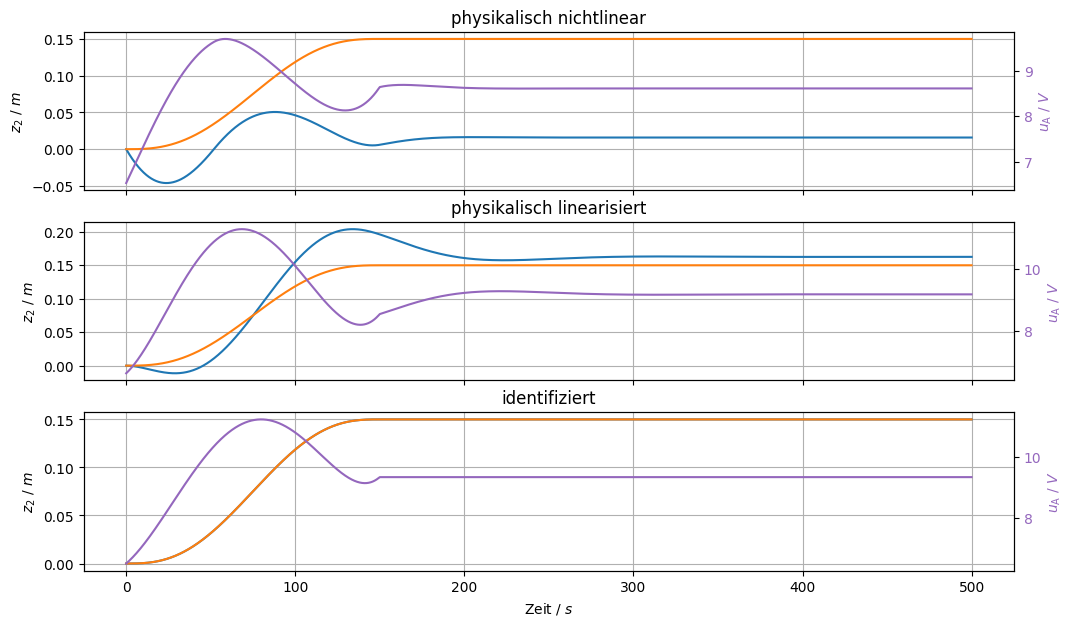

In [55]:
three_stack_plot_FF(timeDom, zNLin, z2NLinFF, uNLin, zLinPhy, z2LinPhyFF, uLinPhy, bz2Phy, zLinMes, z2LinMesFF, uLinMes, bz2Messung)

### 4. Zustandsregler über Regelungsnormalform

Ziel ist der Entwurf eines Zustandsreglers auf Basis des linearisierten Modells des Zweitanksystems.

Dabei wird eine Zustandsrückführung durchgeführt. Diese kann wie folgt entworfen werden:

1. Berechnung der Zustandstransformation:
    
    a) Berechnung der Kalmanschen Steuerbarkeitsmatrix

    \begin{align*}
        S = \left(\mathbf{b}, A\mathbf{b}, \dots, A^{n-1}\mathbf{b} \right)
    \end{align*}

    b) $\mathbf{q}_1^T$ ist die letzte Zeile der inversen von $S$

    c) Berechnung der Transformationsmatrix $Q$

\begin{align*} Q = 
\begin{pmatrix} 
q^T\\
q^T A \\
\vdots \\
q^T A^{n-1}
\end{pmatrix}
\end{align*}

2. Berechnung der Zustandsrückführung
\begin{align*}
    u_{\text{R}}(t) & = -\mathbf{k}^{\intercal} \mathbf{e}(t)
\end{align*}

Die Verstärkungen $\mathbf{k}^{\intercal}$ kann über die Ackermannformel berechnet werden.

In [56]:
A = AGenMessung
B = BGenMessung
c = np.array([0, 1])

In [57]:
# Berechnung der Steuerbarkeitsmatrix
S = np.hstack([B, A.dot(B)])

# Berechnung des Vektors
qT = np.linalg.inv(S)[-1, :]

# Berechnung der Transformationsmatrix Q (in die RNF)
Q = np.array([[qT], [qT.dot(A)]]).reshape(2,2)

# Transformation des Systems in RNF
ARNF = Q.dot(A).dot(np.linalg.inv(Q))
bRNF = Q.dot(B)
cRNF = c.dot(np.linalg.inv(Q))

In [76]:
x0 = (0 - bz2Messung) / cRNF[0]
x1 = (z2Soll - bz2Messung) / cRNF[0]

poles = [-0.5, -1]
kRNF = control.acker(ARNF, bRNF, poles)

In [77]:
regler = ZustandsRegler(kRNF, Q, 0 - buA, 12 - buA, timeDom[1])
steuerung = Steuerung(x0, x1, 0, dt, -ARNF[1, 0], -ARNF[1, 1], bRNF[1])

#### Regler ohne Steuerung

In [78]:
# nichtlineares System
setPoint = np.array([bz2Phy, bz1Phy])
z0 = [0, 0]
zNLin, uNLin = simu_nlin_noFF(regler, timeDom, z0, setPoint)

In [79]:
# lineares System mit physikalischen Parametern
setPoint = np.array([0, 0])
z0 = [0, 0] - np.array([bz2Phy, 0])
zLinPhy, uLinPhy = simu_lin_noFF(regler, timeDom, z0, setPoint, APhyLin, BPhyLin)

In [80]:
# lineares System mit gemessenen Parametern
setPoint = np.array([0, 0])
z0 = [0, 0] - np.array([bz2Messung, 0])
zLinMes, uLinMes = simu_lin_noFF(regler, timeDom, z0, setPoint, AEAMessung, BEAMessung)

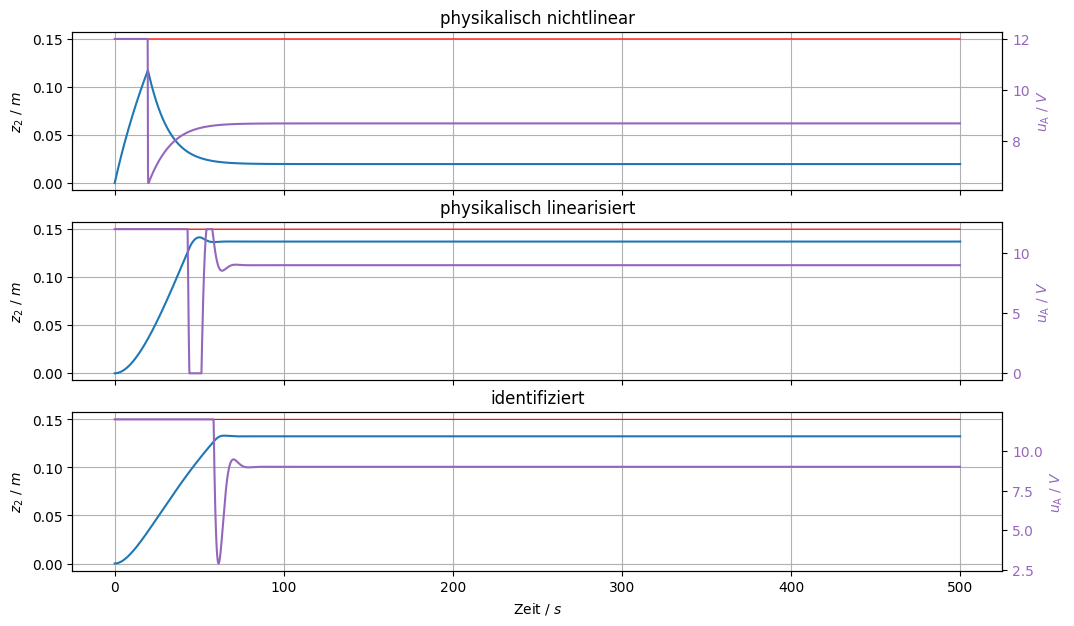

In [81]:
three_stack_plot(timeDom, zNLin, uNLin, zLinPhy, uLinPhy, bz2Phy, zLinMes, uLinMes, bz2Messung, refLine=z2Soll)

#### Regler mit Steuerung

Um den Zustandsregler mit der flachheitsbasierten Steuerung zu realisieren, brauchen wir einen Beobachter für das System, weil der flache Ausgang die Höhe des zweiten Tanks ist und im Zustand dementsprechend auch die Ableitung davon vorkommt. Diese Zustandsgröße wird nicht gemessen, weshalb ein Beobachter entworfen werden muss.

In [24]:
regler = ZustandsRegler(kRNF, Q, 0 - buA, 12 - buA, timeDom[1])
steuerung = Steuerung(x0, x1, 0, dt, -ARNF[1, 0], -ARNF[1, 1], bRNF[1])

In [25]:
# nichtlinears System
z0 = [0, 0]
zNLin, z2NLinFF, uNLin = simu_nlin_withFF(regler, steuerung, timeDom, z0, bz2Messung)

In [26]:
# # lineares System mit physikalischen Parametern
# z0 = [0, 0 ]- np.array([bz2Phy, 0])
zLinPhy, z2LinPhyFF, uLinPhy = simu_lin_withFF(regler, steuerung, timeDom, z0, APhyLin, BPhyLin)

In [31]:
# lineares System mit gemessenen Parametern
z0 = [0, 0 ]- np.array([bz2Messung, 0])
zLinMes, z2LinMesFF, uLinMes = simu_lin_withFF(regler, steuerung, timeDom, z0, AEAMessung, BEAMessung)

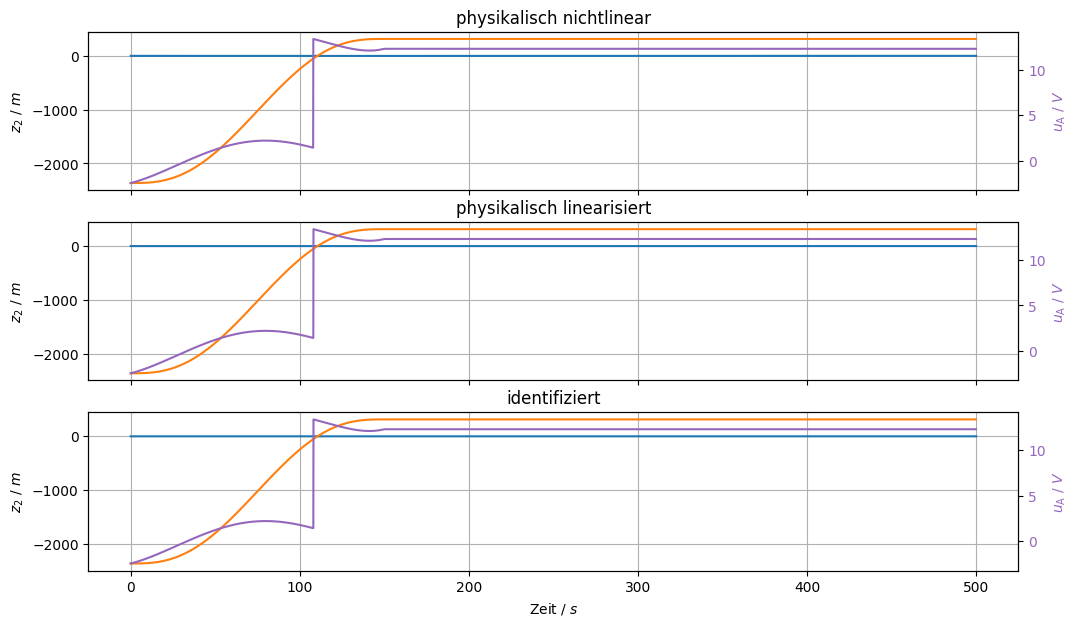

In [32]:
# three_stack_plot(timeDom, zNLin, uNLin, zLinPhy, uLinPhy, bz2Phy, zLinMes, uLinMes, bz2Messung, refLine=z2Soll)
three_stack_plot_FF(timeDom, zNLin, z2NLinFF, uNLin, zLinPhy, z2LinPhyFF, uLinPhy, bz2Phy, zLinMes, z2LinMesFF, uLinMes, bz2Messung)